# IT Academy Data Science Final Project

 
<div class="alert alert-block alert-info">
<b>Simón Luque González</b> </div>

## Image Classifier for Parasitic Egg Detection

<div class="alert alert-block alert-success">
<b>The point of the project will be to train a fully-connected neural network to perform image classification on parasitic eggs. We will be using TensorFlow/Keras to build the neural network and training/validation dataset.</b>
</div>

In [3]:
from tensorflow import keras

2023-01-31 18:44:56.766902: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [4]:
import pandas as pd
import os
import numpy as np
import matplotlib.image as mpimg
import json
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Dropout, MaxPool2D, Flatten
from keras.preprocessing import image 

## 1. Preprocessing the data

In [44]:
# Opening JSON file
f = open('Chula-ParasiteEgg-11/Chula-ParasiteEgg-11/labels.json')
  
# returns JSON object as 
# a dictionary
labels = json.load(f)
  
# Iterating through the json
for i in labels['categories']:
    print(i)
  
# Closing file
f.close()

{'id': 0, 'name': 'Ascaris lumbricoides', 'supercategory': None}
{'id': 1, 'name': 'Capillaria philippinensis', 'supercategory': None}
{'id': 2, 'name': 'Enterobius vermicularis', 'supercategory': None}
{'id': 3, 'name': 'Fasciolopsis buski', 'supercategory': None}
{'id': 4, 'name': 'Hookworm egg', 'supercategory': None}
{'id': 5, 'name': 'Hymenolepis diminuta', 'supercategory': None}
{'id': 6, 'name': 'Hymenolepis nana', 'supercategory': None}
{'id': 7, 'name': 'Opisthorchis viverrine', 'supercategory': None}
{'id': 8, 'name': 'Paragonimus spp', 'supercategory': None}
{'id': 9, 'name': 'Taenia spp. egg', 'supercategory': None}
{'id': 10, 'name': 'Trichuris trichiura', 'supercategory': None}


In [30]:
for i in labels:
    print(i)

info
licenses
categories
images
annotations


In [17]:
df_info = labels['info']
df_info

{'year': '2022',
 'version': '1.00',
 'description': 'Chula-ParasiteEgg-11',
 'contributor': '',
 'url': 'https://icip2022challenge.piclab.ai/',
 'date_created': '2022-01-30T08:01:37'}

### Categories data

In [13]:
df_categories = pd.json_normalize(labels, record_path =['categories'])
df_categories

,id,name,supercategory
0,0,Ascaris lumbricoides,None
1,1,Capillaria philippinensis,None
2,2,Enterobius vermicularis,None
3,3,Fasciolopsis buski,None
4,4,Hookworm egg,None
5,5,Hymenolepis diminuta,None
6,6,Hymenolepis nana,None
7,7,Opisthorchis viverrine,None
8,8,Paragonimus spp,None
9,9,Taenia spp. egg,None


### Images data

In [45]:
df_images = pd.json_normalize(labels, record_path =['images'])
df_images

,id,file_name,height,width,license,coco_url
0,1,Hymenolepis nana_0001.jpg,672,1280,1,None
1,2,Hymenolepis nana_0002.jpg,960,896,1,None
2,3,Hymenolepis nana_0003.jpg,672,1280,1,None
3,4,Hymenolepis nana_0004.jpg,960,1280,1,None
4,5,Hymenolepis nana_0005.jpg,960,1280,1,None
...,...,...,...,...,...,...
10995,10996,Hookworm egg_0996.jpg,3264,1714,1,None
10996,10997,Hookworm egg_0997.jpg,3264,2448,1,None
10997,10998,Hookworm egg_0998.jpg,3264,2448,1,None
10998,10999,Hookworm egg_0999.jpg,2285,2448,1,None


### Annotations data

In [15]:
df_annotations = pd.json_normalize(labels, record_path =['annotations'])
df_annotations

,id,image_id,category_id,bbox,area
0,1,1,6,"[555.0, 76.0, 177.0, 188.0]",33276.0
1,2,2,6,"[549.0, 459.0, 178.0, 151.0]",26878.0
2,3,3,6,"[538.0, 449.0, 206.0, 170.0]",35020.0
3,4,4,6,"[542.0, 384.0, 173.0, 166.0]",28718.0
4,5,5,6,"[483.0, 373.0, 224.0, 190.0]",42560.0
...,...,...,...,...,...
11026,11027,10996,4,"[523.0, 1611.0, 198.0, 262.0]",51876.0
11027,11028,10997,4,"[1353.0, 1482.0, 218.0, 267.0]",58206.0
11028,11029,10998,4,"[1366.0, 1754.0, 171.0, 298.0]",50958.0
11029,11030,10999,4,"[1132.0, 1323.0000000000002, 211.0, 242.0]",51062.0


In [53]:
#Number of images per classes
df_images_per_classes = df_annotations.groupby(['category_id']).size()
df_images_per_classes

category_id
0     1009
1     1000
2     1000
3     1000
4     1010
5     1000
6     1001
7     1000
8     1000
9     1011
10    1000
dtype: int64

### Images in the data folder

In [46]:
base_path = 'Chula-ParasiteEgg-11/Chula-ParasiteEgg-11/'
print(os.listdir(base_path))
print(f'Total images {len(os.listdir(os.path.join(base_path, "data")))}')

['labels.json', '.DS_Store', 'data']
Total images 11000


### Preprocessing of the images and its labels

In [47]:
# Get all image filenames
img_filenames = os.listdir('Chula-ParasiteEgg-11/Chula-ParasiteEgg-11/data')

# Create empty arrays for image data and corresponding labels
images = []
img_labels = []

# Loop through all images and labels
for filename in img_filenames:
    # Open the image and convert to a numpy array
    img = tf.keras.preprocessing.image.load_img(os.path.join('Chula-ParasiteEgg-11/Chula-ParasiteEgg-11/data', filename), target_size=(224,224))
    img = tf.keras.preprocessing.image.img_to_array(img)
    images.append(img)
    # Get label for the image
    label = filename.split('_')[0]
    img_labels.append(label)

# Convert images and labels to numpy arrays
images = np.array(images)
img_labels = np.array(img_labels)

## 2. Data Visualization

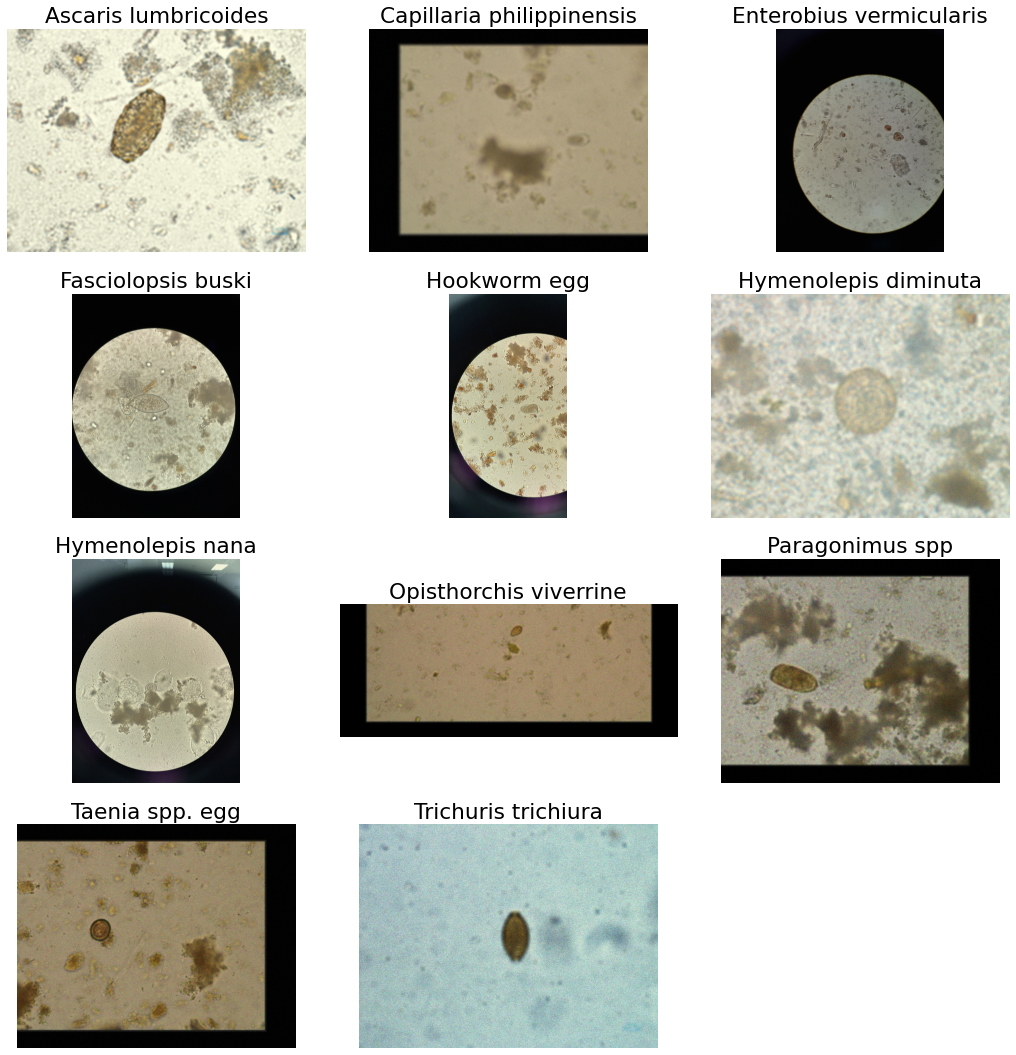

In [48]:
# Get unique labels
unique_labels = np.unique(img_labels)

# Set the figure size and font size
fig = plt.figure(figsize=(15, 15))
plt.rcParams.update({'font.size': 18})

# Define the number of rows and columns for the grid
rows = int(np.ceil(np.sqrt(len(unique_labels))))
cols = int(np.ceil(len(unique_labels) / rows))

# Display one image for each unique label
for i, label in enumerate(unique_labels):
    index = np.where(img_labels == label)[0][0]
    filename = img_filenames[index]
    ax = plt.subplot2grid((rows, cols), (i // cols, i % cols))
    ax.imshow(mpimg.imread(os.path.join('Chula-ParasiteEgg-11/Chula-ParasiteEgg-11/data', filename)))
    ax.set_title(label)
    ax.axis('off')

plt.tight_layout()
plt.show()

## 3. Splitting into train, validation and test set

In [10]:
# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(images, img_labels, test_size=0.2, random_state=42)

# Preprocess the data for CNN
train_datagen = ImageDataGenerator(rescale=1./255,
                                   validation_split=0.2)

# Create the train and test data generators
train_gen = train_datagen.flow(X_train, y_train, batch_size=32, subset='training')
val_gen = train_datagen.flow(X_train, y_train, batch_size=32, subset='validation')

## 4. Model Building, Training and Evaluation

In [11]:
# Encoding using LabelEncoder
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_test = le.transform(y_test)

# Model creation
model = tf.keras.Sequential()
model.add(tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(224,224,3)))
model.add(tf.keras.layers.MaxPooling2D((2,2)))
model.add(tf.keras.layers.Conv2D(64, (3,3), activation='relu'))
model.add(tf.keras.layers.MaxPooling2D((2,2)))
model.add(tf.keras.layers.Conv2D(128, (3,3), activation='relu'))
model.add(tf.keras.layers.MaxPooling2D((2,2)))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(128, activation='relu'))
model.add(tf.keras.layers.Dense(11, activation='softmax'))

# Model compiling
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Model training
history = model.fit(
    X_train, y_train,
    epochs=10,
    validation_data=(X_test, y_test)
)

# Evaluating the model on the test data
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
print('Test Accuracy:', test_acc)

2023-02-08 22:35:20.039565: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/10
275/275 [==============================] - 274s 990ms/step - loss: 11.5488 - accuracy: 0.1151 - val_loss: 2.3451 - val_accuracy: 0.1336
Epoch 2/10
275/275 [==============================] - 269s 978ms/step - loss: 2.2945 - accuracy: 0.1587 - val_loss: 2.2900 - val_accuracy: 0.1405
Epoch 3/10
275/275 [==============================] - 256s 932ms/step - loss: 2.1946 - accuracy: 0.1895 - val_loss: 2.2904 - val_accuracy: 0.1714
Epoch 4/10
275/275 [==============================] - 254s 923ms/step - loss: 2.0528 - accuracy: 0.2512 - val_loss: 2.2941 - val_accuracy: 0.1777
Epoch 5/10
275/275 [==============================] - 255s 928ms/step - loss: 1.9186 - accuracy: 0.3017 - val_loss: 2.3624 - val_accuracy: 0.1736
Epoch 6/10
275/275 [==============================] - 726s 3s/step - loss: 1.9597 - accuracy: 0.2828 - val_loss: 2.5450 - val_accuracy: 0.1545
Epoch 7/10
275/275 [==============================] - 255s 928ms/step - loss: 1.8410 - accuracy: 0.3335 - val_loss: 2.6194 - v

In [18]:
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 54, 54, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 52, 52, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 26, 26, 128)      0

## 5. Visualizing model performance

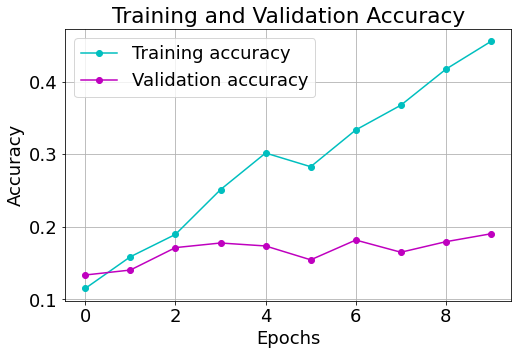

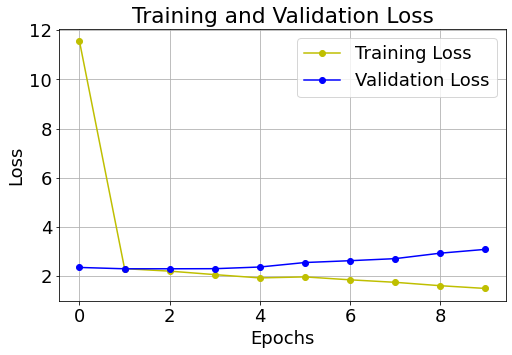

In [36]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))
plt.figure(figsize=(8,5))

plt.plot(epochs, acc, 'co-', label='Training accuracy')
plt.plot(epochs, val_acc, 'mo-', label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.figure(figsize=(8,5))

plt.plot(epochs, loss, 'yo-', label='Training Loss')
plt.plot(epochs, val_loss, 'bo-', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.show()

## Conclusions

<div class="alert alert-block alert-warning">
<b>The model would have to be improved to increase its accuracy</b><br>
    <b>Possible solutions:</b>

    1. Data augmentation.

    2. Use a different architecture.

    3. Increase the number of epochs.

    4. Adjust the hyperparameters: Adjusting the hyperparameters such as the number of filters in the convolutional layers, the size of the fully connected layers, and the batch size to see if it improves the accuracy. 
</div>